packageのインストール方法
juliaを別途ターミナルから立ち上げて以下を入力

```
$ julia
julia> ここで]をおしてパッケージ管理モードに入る
(@v1.8) pkg> add CUDA Plots Revise
(@v1.8) pkg> add https://github.com/matsunagalab/MDToolbox.jl.git
(@v1.8) pkg> deleteをおしてパッケージ管理モードを抜ける
julia> Ctrl-dをおしてjuliaを終了
```

In [1]:
using CUDA
#using HTTP
using DelimitedFiles
using Plots
using ChainRulesCore
using ProgressMeter
using Revise
using MDToolbox

In [2]:

################ grid

function generate_grid(receptor_org::TrjArray{T,U}, ligand_org::TrjArray{T,U}; iframe=1, spacing=1.2) where {T,U}
    receptor = deepcopy(receptor_org)
    ligand = deepcopy(ligand_org)
    decenter!(receptor)
    orient!(ligand)
    xmin_ligand = minimum(ligand.xyz[iframe, 1:3:end])
    xmax_ligand = maximum(ligand.xyz[iframe, 1:3:end])
    size_ligand = xmax_ligand - xmin_ligand

    xmin_receptor = minimum(receptor.xyz[iframe, 1:3:end])
    xmax_receptor = maximum(receptor.xyz[iframe, 1:3:end])
    xmin_grid = xmin_receptor - size_ligand - spacing
    xmax_grid = xmax_receptor + size_ligand + spacing

    ymin_receptor = minimum(receptor.xyz[iframe, 2:3:end])
    ymax_receptor = maximum(receptor.xyz[iframe, 2:3:end])
    ymin_grid = ymin_receptor - size_ligand - spacing
    ymax_grid = ymax_receptor + size_ligand + spacing

    zmin_receptor = minimum(receptor.xyz[iframe, 3:3:end])
    zmax_receptor = maximum(receptor.xyz[iframe, 3:3:end])
    zmin_grid = zmin_receptor - size_ligand - spacing
    zmax_grid = zmax_receptor + size_ligand + spacing

    x_grid = Array{T,1}(range(xmin_grid, xmax_grid, step=spacing))
    if typeof(receptor_org.xyz) <: CuArray
        x_grid = CuArray(x_grid)
    end

    y_grid = Array{T,1}(range(ymin_grid, ymax_grid, step=spacing))
    if typeof(receptor_org.xyz) <: CuArray
        y_grid = CuArray(y_grid)
    end

    z_grid = Array{T,1}(range(zmin_grid, zmax_grid, step=spacing))
    if typeof(receptor_org.xyz) <: CuArray
        z_grid = CuArray(z_grid)
    end

    nx = length(x_grid)
    ny = length(y_grid)
    nz = length(z_grid)

    grid_real = similar(receptor_org.xyz, (nx, ny, nz))
    grid_real .= zero(T)
    grid_imag = similar(receptor_org.xyz, (nx, ny, nz))
    grid_imag .= zero(T)

    return grid_real, grid_imag, x_grid, y_grid, z_grid
end

function spread_nearest_add!(grid::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    weight::AbstractVector{T}) where {T}

    natom = length(x)
    x_grid_delta = x_grid[2] - x_grid[1]
    y_grid_delta = y_grid[2] - y_grid[1]
    z_grid_delta = z_grid[2] - z_grid[1]

    x_grid_min = x_grid[1]
    y_grid_min = y_grid[1]
    z_grid_min = z_grid[1]

    for iatom = 1:natom
        ix = ceil(Int, (x[iatom] - x_grid_min) / x_grid_delta)
        iy = ceil(Int, (y[iatom] - y_grid_min) / y_grid_delta)
        iz = ceil(Int, (z[iatom] - z_grid_min) / z_grid_delta)
        grid[ix, iy, iz] += weight[iatom]
    end

    return nothing
end

function spread_nearest_substitute!(grid::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    weight::AbstractVector{T}) where {T}

    natom = length(x)
    x_grid_delta = x_grid[2] - x_grid[1]
    y_grid_delta = y_grid[2] - y_grid[1]
    z_grid_delta = z_grid[2] - z_grid[1]

    x_grid_min = x_grid[1]
    y_grid_min = y_grid[1]
    z_grid_min = z_grid[1]

    for iatom = 1:natom
        ix = ceil(Int, (x[iatom] - x_grid_min) / x_grid_delta)
        iy = ceil(Int, (y[iatom] - y_grid_min) / y_grid_delta)
        iz = ceil(Int, (z[iatom] - z_grid_min) / z_grid_delta)
        grid[ix, iy, iz] = weight[iatom]
    end

    return nothing
end

function spread_neighbors_add!(grid::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    weight::AbstractVector{T}, rcut::AbstractVector{T}) where {T}

    natom = length(x)
    nx, ny, nz = size(grid)
    for iatom = 1:natom
        for ix = 1:nx
            dx = x[iatom] - x_grid[ix]
            if abs(dx) > rcut[iatom]
                continue
            end
            for iy = 1:ny
                dy = y[iatom] - y_grid[iy]
                if abs(dy) > rcut[iatom]
                    continue
                end
                for iz = 1:nz
                    dz = z[iatom] - z_grid[iz]
                    if abs(dz) > rcut[iatom]
                        continue
                    end
                    d = dx * dx + dy * dy + dz * dz
                    if d < rcut[iatom] * rcut[iatom]
                        grid[ix, iy, iz] += weight[iatom]
                    end
                end
            end
        end
    end

    return nothing
end


function spread_neighbors_substitute!(grid::AbstractArray{T2},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    weight::AbstractVector{T}, rcut::AbstractVector{T}) where {T2,T}

    natom = length(x)
    nx, ny, nz = size(grid)

    for iatom = 1:natom
        for ix = 1:nx
            dx = x[iatom] - x_grid[ix]
            if abs(dx) > rcut[iatom]
                continue
            end
            for iy = 1:ny
                dy = y[iatom] - y_grid[iy]
                if abs(dy) > rcut[iatom]
                    continue
                end
                for iz = 1:nz
                    dz = z[iatom] - z_grid[iz]
                    if abs(dz) > rcut[iatom]
                        continue
                    end
                    d = dx * dx + dy * dy + dz * dz
                    if d < rcut[iatom] * rcut[iatom]
                        grid[ix, iy, iz] = weight[iatom]
                    end
                end
            end
        end
    end

    return nothing
end


#####################################################

function assign_sc_receptor_plus!(grid_real::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

    
    grid_real .= zero(T)

    
    x_s = x[id_surface]
    y_s = y[id_surface]
    z_s = z[id_surface]
    radius_s = radius[id_surface]
    weight_s = similar(radius_s)

    x_c = x[.!id_surface]
    y_c = y[.!id_surface]
    z_c = z[.!id_surface]
    radius_c = radius[.!id_surface]
    weight_c = similar(radius_c)

    weight_s .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .+ T(3.4))
    weight_s .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .* T(sqrt(0.8)))
    weight_c .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
    
    return nothing
end

function assign_sc_ligand_plus!(grid_real::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

    
    grid_real .= zero(T)

    
    x_s = x[id_surface]
    y_s = y[id_surface]
    z_s = z[id_surface]
    radius_s = radius[id_surface]
    weight_s = similar(radius_s)

    x_c = x[.!id_surface]
    y_c = y[.!id_surface]
    z_c = z[.!id_surface]
    radius_c = radius[.!id_surface]
    weight_c = similar(radius_c)

    weight_s .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s)

    weight_c .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
    
    return nothing
end

function assign_sc_receptor_minus!(grid_imag::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

    
    grid_imag .= zero(T)

    
    x_s = x[id_surface]
    y_s = y[id_surface]
    z_s = z[id_surface]
    radius_s = radius[id_surface]
    weight_s = similar(radius_s)

    x_c = x[.!id_surface]
    y_c = y[.!id_surface]
    z_c = z[.!id_surface]
    radius_c = radius[.!id_surface]
    weight_c = similar(radius_c)

    weight_s .= T(3.0)
    spread_neighbors_substitute!(grid_imag, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .+ T(3.4))
    weight_s .= T(9.0)
    spread_neighbors_substitute!(grid_imag, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .* T(sqrt(0.8)))
    weight_c .= T(9.0)
    spread_neighbors_substitute!(grid_imag, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
    
    return nothing
end
    
function assign_sc_ligand_minus!(grid_imag::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

    
    grid_imag .= zero(T)

    
    x_s = x[id_surface]
    y_s = y[id_surface]
    z_s = z[id_surface]
    radius_s = radius[id_surface]
    weight_s = similar(radius_s)

    x_c = x[.!id_surface]
    y_c = y[.!id_surface]
    z_c = z[.!id_surface]
    radius_c = radius[.!id_surface]
    weight_c = similar(radius_c)

    weight_s .= T(3.0)
    spread_neighbors_substitute!(grid_imag, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s)

    weight_c .= T(9.0)
    spread_neighbors_substitute!(grid_imag, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
    
    return nothing
end
###################################################

function assign_sc_receptor!(grid_real::AbstractArray{T}, grid_imag::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

    grid_real .= zero(T)
    grid_imag .= zero(T)

    x_s = x[id_surface]
    y_s = y[id_surface]
    z_s = z[id_surface]
    radius_s = radius[id_surface]
    weight_s = similar(radius_s)

    x_c = x[.!id_surface]
    y_c = y[.!id_surface]
    z_c = z[.!id_surface]
    radius_c = radius[.!id_surface]
    weight_c = similar(radius_c)

    weight_s .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .+ T(3.4))
    weight_s .= T(0.0)
    spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .* T(sqrt(0.8)))
    weight_c .= T(0.0)
    spread_neighbors_substitute!(grid_real, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))

    weight_s .= T(9.0)
    spread_neighbors_substitute!(grid_imag, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .* T(sqrt(0.8)))
    weight_c .= T(9.0)
    spread_neighbors_substitute!(grid_imag, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
    return nothing
end

function assign_sc_ligand!(grid_real::AbstractArray{T}, grid_imag::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

    grid_real .= zero(T)
    grid_imag .= zero(T)

    x_s = x[id_surface]
    y_s = y[id_surface]
    z_s = z[id_surface]
    radius_s = radius[id_surface]
    weight_s = similar(radius_s)

    x_c = x[.!id_surface]
    y_c = y[.!id_surface]
    z_c = z[.!id_surface]
    radius_c = radius[.!id_surface]
    weight_c = similar(radius_c)
    
    weight_s .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s)

    weight_c .= T(9.0)
    spread_neighbors_substitute!(grid_imag, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))

    # check_neighbors_ligand!(grid_real, grid_imag)

    return nothing
end

function assign_Rij!(grid_real::AbstractArray{T}, 
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    iface_ij::AbstractVector{T}) where {T}

    grid_real .= zero(T)

    radius = similar(iface_ij)
    radius .= T(6.0)
    spread_neighbors_add!(grid_real, x, y, z, x_grid, y_grid, z_grid, iface_ij, radius)

    return nothing
end

function assign_Li!(grid_real::AbstractArray{T}, 
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T}
    ) where {T}

    grid_real .= zero(T)

    radius = similar(x)
    radius .= T(1.0)
    spread_nearest_substitute!(grid_real, x, y, z, x_grid, y_grid, z_grid, radius)

    return nothing
end

# function assign_ds!(grid_real::AbstractArray{T}, grid_imag::AbstractArray{T},
#     x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
#     x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
#     iface_ij::AbstractVector{T}) where {T}

#     grid_real .= zero(T)
#     grid_imag .= zero(T)

#     radius = similar(iface_ij)
#     radius .= T(6.0)
#     spread_neighbors_add!(grid_real, x, y, z, x_grid, y_grid, z_grid, iface_ij, radius)

#     radius .= T(1.0)
#     spread_nearest_substitute!(grid_imag, x, y, z, x_grid, y_grid, z_grid, radius)

#     return nothing
# end

################ docking

# function docking_score(receptor_org::TrjArray{T,U},
#         ligands_org::TrjArray{T,U}, alpha::T, iface_ij::AbstractArray{T}, 
#         beta::T, charge_score::AbstractArray{T}) where {T,U}

function docking_score(receptor_org::TrjArray{T,U},
        ligands_org::TrjArray{T,U}, alpha::T, iface_ij::AbstractArray{T}) where {T,U}    
    spacing = 3.0
    receptor = deepcopy(receptor_org)
    ligands = deepcopy(ligands_org)

    decenter!(receptor)
    decenter!(ligands)

    grid_real, grid_imag, x_grid, y_grid, z_grid = generate_grid(receptor, ligands, spacing=spacing)
    nxyz = T(prod(size(grid_real)))

    com = centerofmass(receptor)
    receptor.xyz[:, 1:3:end] .= receptor.xyz[:, 1:3:end] .- com.xyz[:, 1:1]
    receptor.xyz[:, 2:3:end] .= receptor.xyz[:, 2:3:end] .- com.xyz[:, 2:2]
    receptor.xyz[:, 3:3:end] .= receptor.xyz[:, 3:3:end] .- com.xyz[:, 3:3]
    ligands.xyz[:, 1:3:end] .= ligands.xyz[:, 1:3:end] .- com.xyz[:, 1:1]
    ligands.xyz[:, 2:3:end] .= ligands.xyz[:, 2:3:end] .- com.xyz[:, 2:2]
    ligands.xyz[:, 3:3:end] .= ligands.xyz[:, 3:3:end] .- com.xyz[:, 3:3]

    # receptor.mass .= iface_ij[receptor.atomtype_id]
    # ligands.mass .= iface_ij[ligands.atomtype_id]

    x = receptor.xyz[1, 1:3:end]
    y = receptor.xyz[1, 2:3:end]
    z = receptor.xyz[1, 3:3:end]
    id_surface = receptor.sasa .> 1.0

    ##########################################
    
    # assign_sc_receptor_plus!(grid_real, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    # assign_sc_receptor_minus!(grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    assign_sc_receptor!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    grid_sc_receptor = grid_real .+ im .* grid_imag
    
    ##########################################

    # assign_ds!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.mass)
    # grid_ds_receptor = grid_real .+ im .* grid_imag

    x = ligands.xyz[1, 1:3:end]
    y = ligands.xyz[1, 2:3:end]
    z = ligands.xyz[1, 3:3:end]

    x2 = receptor.xyz[1, 1:3:end]
    y2 = receptor.xyz[1, 2:3:end]
    z2 = receptor.xyz[1, 3:3:end]

    id_surface = ligands.sasa .> 1.0

    grid_sc_ligand = deepcopy(grid_sc_receptor)
    # grid_iface_ligand = deepcopy(grid_real)
    # grid_iface_receptor = deepcopy(grid_real)
    score_sc = similar(grid_real, ligands.nframe)
    score_iface = similar(grid_real, ligands.nframe)
    score_iface .= zero(T)
    score_total = similar(grid_real, ligands.nframe)

    @showprogress for iframe = 1:ligands.nframe
        x .= ligands.xyz[iframe, 1:3:end]
        y .= ligands.xyz[iframe, 2:3:end]
        z .= ligands.xyz[iframe, 3:3:end]

        ###################################################
        
        assign_sc_ligand!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
        grid_sc_ligand .= grid_real .+ im .* grid_imag
        multi = grid_sc_receptor .* grid_sc_ligand
        score_sc[iframe] = sum(real.(multi)) - sum(imag.(multi))

        # assign_sc_ligand_plus!(grid_real, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
        # assign_sc_ligand_minus!(grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
        # grid_sc_ligand .= grid_real .+ im .* grid_imag 
        # multi = grid_sc_receptor .* grid_sc_ligand
        # score_sc[iframe] = sum(real.(multi)) - sum(imag.(multi)) 
        
        
        ##################################################        
        
        # assign_ds!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.mass)
        # grid_ds_ligand .= grid_real .+ im .* grid_imag
        # multi = grid_ds_receptor .* grid_ds_ligand
        # score_ds[iframe] = T(0.5) * sum(imag(multi))

        for i = 1:12
            idx = ligands.atomtype_id .== i 
            assign_Li!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid)
            for j = 1:12
                k = 12 * (j-1) + i 
                receptor.mass .= iface_ij[k]
                idx = receptor.atomtype_id .== j
                assign_Rij!(grid_imag, x2[idx], y2[idx], z2[idx], x_grid, y_grid, z_grid, receptor.mass[idx])
                score_iface[iframe] += sum(grid_real .* grid_imag)
            end
        end 
        
        # for g = 1:11
        #     idx = ligands.atomtype_id .== g
        #     ligands.mass .= charge_score
        #     assign_charge!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid, ligand.mass[idx])
        #     score_elec[iframe] += sum(grid_real)
        # end


        score_total[iframe] = alpha .* score_sc[iframe] .+ score_iface[iframe] #.- beta .* score_elec[iframe]
    end

    return score_total
end


docking_score (generic function with 1 method)

In [3]:
function ChainRulesCore.rrule(::typeof(MDToolbox.docking_score), receptor_org::TrjArray{T,U}, ligands_org::TrjArray{T,U}, alpha::T, iface_ij::AbstractVector{T}) where {T,U}
    spacing = 1.5
    receptor = deepcopy(receptor_org)
    ligands = deepcopy(ligands_org)

    decenter!(receptor)
    decenter!(ligands)

    grid_real, grid_imag, x_grid, y_grid, z_grid = MDToolbox.generate_grid(receptor, ligands, spacing=spacing)
    nxyz = T(prod(size(grid_real)))

    com = centerofmass(receptor)
    receptor.xyz[:, 1:3:end] .= receptor.xyz[:, 1:3:end] .- com.xyz[:, 1:1]
    receptor.xyz[:, 2:3:end] .= receptor.xyz[:, 2:3:end] .- com.xyz[:, 2:2]
    receptor.xyz[:, 3:3:end] .= receptor.xyz[:, 3:3:end] .- com.xyz[:, 3:3]
    ligands.xyz[:, 1:3:end] .= ligands.xyz[:, 1:3:end] .- com.xyz[:, 1:1]
    ligands.xyz[:, 2:3:end] .= ligands.xyz[:, 2:3:end] .- com.xyz[:, 2:2]
    ligands.xyz[:, 3:3:end] .= ligands.xyz[:, 3:3:end] .- com.xyz[:, 3:3]

    # receptor.mass .= iface_ij[receptor.atomtype_id]
    # ligands.mass .= iface_ij[ligands.atomtype_id]

    x = receptor.xyz[1, 1:3:end]
    y = receptor.xyz[1, 2:3:end]
    z = receptor.xyz[1, 3:3:end]
    id_surface = receptor.sasa .> 1.0

    MDToolbox.assign_sc_receptor!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    grid_sc_receptor = grid_real .+ im .* grid_imag

    # assign_ds!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.mass)
    # grid_ds_receptor = grid_real .+ im .* grid_imag

    x = ligands.xyz[1, 1:3:end]
    y = ligands.xyz[1, 2:3:end]
    z = ligands.xyz[1, 3:3:end]

    x2 = receptor.xyz[1, 1:3:end]
    y2 = receptor.xyz[1, 2:3:end]
    z2 = receptor.xyz[1, 3:3:end]

    id_surface = ligands.sasa .> 1.0

    grid_sc_ligand = deepcopy(grid_sc_receptor)

    score_sc = similar(grid_real, ligands.nframe)
    score_iface = similar(grid_real, ligands.nframe)
    score_iface .= zero(T)
    score_total = similar(grid_real, ligands.nframe)

    # @showprogress 
    for iframe = 1:ligands.nframe
        x .= ligands.xyz[iframe, 1:3:end]
        y .= ligands.xyz[iframe, 2:3:end]
        z .= ligands.xyz[iframe, 3:3:end]

        MDToolbox.assign_sc_ligand!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
        grid_sc_ligand .= grid_real .+ im .* grid_imag
        multi = grid_sc_receptor .* grid_sc_ligand
        score_sc[iframe] = sum(real.(multi)) - sum(imag.(multi))

        # assign_ds!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.mass)
        # grid_ds_ligand .= grid_real .+ im .* grid_imag
        # multi = grid_ds_receptor .* grid_ds_ligand
        # score_ds[iframe] = T(0.5) * sum(imag(multi))

        for i = 1:12
            idx = ligands.atomtype_id .== i
            if any(idx)
                MDToolbox.assign_Li!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid)
                for j = 1:12
                    k = 12 * (j-1) + i 
                    receptor.mass .= iface_ij[k]
                    idx = receptor.atomtype_id .== j
                    if any(idx)
                        MDToolbox.assign_Rij!(grid_imag, x2[idx], y2[idx], z2[idx], x_grid, y_grid, z_grid, receptor.mass[idx])
                        score_iface[iframe] += sum(grid_real .* grid_imag)
                    end
                end
            end
        end 
        score_total[iframe] = alpha .* score_sc[iframe] .+ score_iface[iframe]
    end
    score_sc_old = deepcopy(score_sc)

    score_for_ifacescore = similar(grid_real, length(iface_ij), ligands.nframe)
    receptor.mass .= one(T)
    
    for iframe = 1:ligands.nframe
        x .= ligands.xyz[iframe, 1:3:end]
        y .= ligands.xyz[iframe, 2:3:end]
        z .= ligands.xyz[iframe, 3:3:end]
    
        for i = 1:12
            idx = ligands.atomtype_id .== i
            if any(idx)
                MDToolbox.assign_Li!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid)
                for j = 1:12
                    k = 12 * (j-1) + i 
                    idx = receptor.atomtype_id .== j
                    if any(idx)
                        MDToolbox.assign_Rij!(grid_imag, x2[idx], y2[idx], z2[idx], x_grid, y_grid, z_grid, receptor.mass[idx])
                        score_for_ifacescore[k, iframe] = sum(grid_real .* grid_imag)
                    end
                end
            end
        end 
    end

    function docking_score_pullback(ybar)
        return NoTangent(), NoTangent(), NoTangent(), sum(score_sc_old .* ybar), score_for_ifacescore * ybar
    end

    return score_total, docking_score_pullback
end

In [4]:
device!(1)

CuDevice(1): Quadro RTX 8000

In [5]:
CUDA.cu(rand(3,3))

3×3 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.537322  0.399049  0.153394
 0.831669  0.98797   0.691104
 0.161076  0.912906  0.621517

In [6]:
ENV["COLUMNS"]=130; #display width for MDToolbox

# load deocoy structures

In [7]:
ntop = 100

100

In [8]:
pdb = mdload("1KXQ/complex.1.pdb")
receptor = pdb[1:1, 1:3908]
ligands = pdb[1:1, 3909:end]

for i = 2:ntop
    pdb = mdload("1KXQ/complex.$(i).pdb")
    ligands = [ligands; pdb[1:1, 3909:end]]
end

In [9]:
d = readdlm("1KXQ/1KXQ.zd3.0.2.fg.fixed.out.rmsds")
rmsds = d[1:ntop, 2]

100-element Vector{Float64}:
 11.19
  4.77
  4.77
 11.54
  4.29
  4.53
  5.33
  4.24
  4.42
 11.44
  3.89
  4.31
 11.12
  ⋮
 19.84
  0.93
 19.86
 19.66
 12.17
  5.03
  2.18
 12.62
 15.78
  4.79
  8.78
 19.18

# prepare docking score calculation

In [10]:
# vdW radius
receptor = MDToolbox.set_radius(receptor)
ligands = MDToolbox.set_radius(ligands);

In [11]:
# charge
# receptor = MDToolbox.set_charge(receptor)
# ligands = MDToolbox.set_charge(ligands);

In [12]:
# SASA
receptor = MDToolbox.compute_sasa(receptor)
ligands = MDToolbox.compute_sasa(ligands);

In [13]:
# ACE scores
receptor = MDToolbox.set_atomtype_id(receptor)
ligands = MDToolbox.set_atomtype_id(ligands)

iface_score = MDToolbox.get_iface_ij()
receptor = TrjArray(receptor, mass=iface_score[receptor.atomtype_id])
ligands = TrjArray(ligands, mass=iface_score[ligands.atomtype_id]);

In [14]:
CUDA.device!(0)

CuDevice(0): Quadro RTX 8000

In [15]:
device!(1)

CuDevice(1): Quadro RTX 8000

In [16]:
gpu(receptor)

1x3908 TrjArray{Float32, Int32}
|                            |                            |  …                              |                            |
| 1GLN                       | 1GLN                       |  …   496LEU                     | 496LEU                     |
| 1N                         | 2CA                        |  …   3907CD2                    | 3908OXT                    |
|    14.38    -5.73    -7.54 |    13.09    -6.25    -7.94 |  …       6.66    -4.83    33.17 |    12.19    -5.56    32.58 |

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007fa2bbeae720.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore should be avoided.
│ 
│ If you want to allow scalar iteration, use `allowscalar` or `@allowscalar`
│ to enable scalar iteration globally or for the operations in question.
└ @ GPUArraysCore /opt/julia_depot/packages/GPUArraysCore/GMsgk/src/GPUArraysCore.jl:149


In [17]:
 receptor = gpu(receptor)

1x3908 TrjArray{Float32, Int32}
|                            |                            |  …                              |                            |
| 1GLN                       | 1GLN                       |  …   496LEU                     | 496LEU                     |
| 1N                         | 2CA                        |  …   3907CD2                    | 3908OXT                    |
|    14.38    -5.73    -7.54 |    13.09    -6.25    -7.94 |  …       6.66    -4.83    33.17 |    12.19    -5.56    32.58 |

In [18]:
if CUDA.functional()
    receptor = gpu(receptor)
    ligands = gpu(ligands)
end

100x916 TrjArray{Float32, Int32}
| H                          | H                          |  …   H                          | H                          |
| 1GLN                       | 1GLN                       |  …   120SER                     | 120SER                     |
| 18396N                     | 18397CA                    |  …   19310CB                    | 19311OXT                   |
|   -13.27    -8.89    -5.81 |   -12.60    -9.06    -7.12 |  …     -18.22    26.19   -28.69 |   -20.37    26.92   -27.07 |
|   -25.91    20.33    -7.94 |   -26.76    20.68    -9.09 |        -41.48   -14.84   -25.23 |   -39.48   -16.32   -23.97 |
|   -24.02    21.38    -7.94 |   -24.83    21.83    -9.09 |        -43.18   -11.96   -25.23 |   -41.35   -13.64   -23.97 |
|   -12.59    -9.93    -6.26 |   -12.08   -10.04    -7.65 |        -21.67    25.41   -27.41 |   -23.63    26.01   -25.52 |
|   -25.63    20.16    -7.06 |   -26.43    20.68    -8.19 |        -41.82   -12.11   -28.86 |   -39.92   -

In [19]:
#receptor.xyz

In [20]:
#ligands.xyz

# perform docking score calculation for decoy structures

In [21]:
 current_score = MDToolbox.docking_score(receptor, ligands, 0.01f0, CUDA.cu(iface_score[1:end]))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


100-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 -3084.2217
 -1566.3383
 -1678.9113
 -3212.4812
 -1711.6128
 -1611.9282
 -1654.1881
 -1549.2799
 -1472.3729
 -2870.1604
 -1939.2631
 -1629.099
 -3594.5876
     ⋮
 -3429.646
 -2717.5593
 -5009.084
 -4051.1628
 -3259.8232
 -1543.9319
 -3296.044
 -2788.1836
 -3021.811
 -1678.8148
 -1952.6641
 -1745.278

In [22]:
 # current_score_2 = docking_score(receptor, ligands, 0.01f0, CUDA.cu(iface_score[1:end]))

In [23]:
 # current_score = MDToolbox.docking_score(receptor, ligands, 0.01, iface_score[1:end])

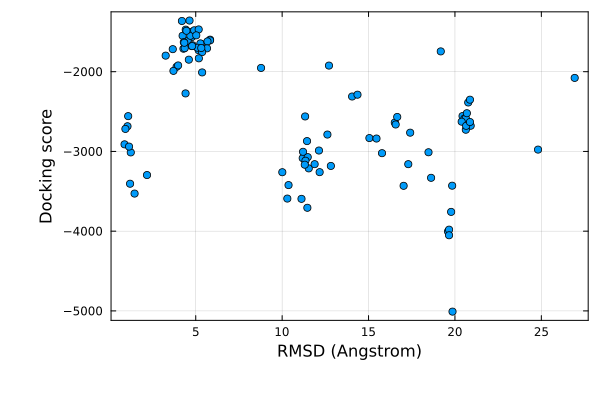

In [24]:
scatter(rmsds, current_score, 
        label=nothing, 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:topright, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

# create ideal scores as training data

In [25]:
# create training score
x1 = minimum(rmsds)
x2 = maximum(rmsds)

y1 = maximum(current_score)
y2 = minimum(current_score)

train_score = zeros(Float64, ntop)
for i = 1:ntop
    train_score[i] = (y2 - y1) / (x2 - x1) * (rmsds[i] - x1) + y1
end

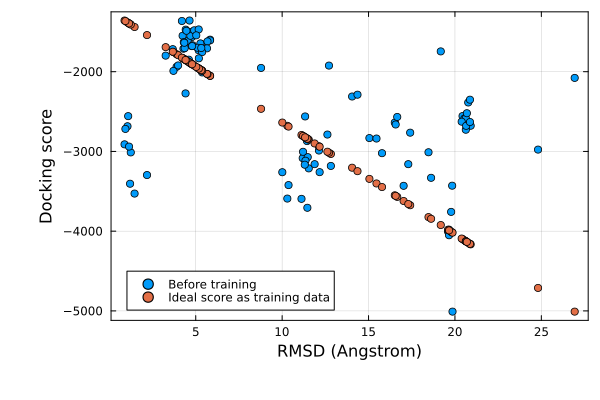

In [26]:
scatter(rmsds, current_score, 
        label="Before training", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:topright, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds, train_score, 
        label="Ideal score as training data", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, color=2, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

# define the docking score function as a layer of neural net framework (Flux.jl)

In [27]:
#ニューラルネットワークフレームワーク(Flux)のレイヤとしてドッキングスコア評価関数を定義

using Flux

struct DockingScore
    A::AbstractArray
    iface_score::AbstractArray
end

DockingScore() = DockingScore(CUDA.cu([0.01f0]), deepcopy(CUDA.cu(iface_score[1:end])))

Flux.@functor DockingScore (A,iface_score)

(m::DockingScore)(x) = MDToolbox.docking_score(x[1], x[2], m.A[1], m.iface_score[1:end])

In [28]:
#ニューラルネットワークフレームワーク(Flux)のレイヤとしてドッキングスコア評価関数を定義

# using Flux

# struct DockingScore
#     A::AbstractArray
#     iface_score::AbstractArray
# end

# DockingScore() = DockingScore(0.01), deepcopy(iface_score[1:end])

# Flux.@functor DockingScore (A,iface_score)

# (m::DockingScore)(x) = MDToolbox.docking_score(x[1], x[2], m.A[1], m.iface_score[1:end])

In [29]:
# パラメータとして alpha と aces_core が認識されていることを確認
m = DockingScore()
ps = Flux.params(m)

Params([Float32[0.01], Float32[0.678, 0.133, -0.007, 0.727, 0.091, -0.742, -0.625, -0.064, -0.382, -0.302  …  0.109, 0.477, -0.034, -0.867, -1.04, 0.822, 0.757, -0.572, 0.731, 0.399]])

In [30]:
ps = ps |> Flux.gpu

Params([Float32[0.01], Float32[0.678, 0.133, -0.007, 0.727, 0.091, -0.742, -0.625, -0.064, -0.382, -0.302  …  0.109, 0.477, -0.034, -0.867, -1.04, 0.822, 0.757, -0.572, 0.731, 0.399]])

In [31]:
train_score = CUDA.cu(train_score)

100-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 -2803.1873
 -1903.4507
 -1903.4507
 -2852.2385
 -1836.1807
 -1869.8157
 -1981.9324
 -1829.1733
 -1854.3995
 -2838.2239
 -1780.1222
 -1838.9835
 -2793.3772
     ⋮
 -4015.4495
 -1365.2904
 -4018.2524
 -3990.2231
 -2940.5303
 -1939.8885
 -1540.4728
 -3003.596
 -3446.457
 -1906.2535
 -2465.4358
 -3922.9531

In [32]:
# 勾配降下法によるパラメータの最適化

loss(receptor_ligands, train_scores) = sum(Flux.Losses.mse.(m.(receptor_ligands), train_scores))

train_loader = Flux.Data.DataLoader((data=[(receptor, ligands)], label=[train_score]), batchsize=1, shuffle=false);

opt = ADAM(0.1)
    
loss_train = []
for epoch in 1:5
    for (x, y) in train_loader
        gs = gradient(() -> loss(x, y), ps)
        Flux.Optimise.update!(opt, ps, gs)
    end
    push!(loss_train, loss([(receptor, ligands)], [train_score]))
end

LoadError: GPU compilation of MethodInstance for (::GPUArrays.var"#34#36")(::CUDA.CuKernelContext, ::CuDeviceVector{Float32, 1}, ::Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{1, CUDA.Mem.DeviceBuffer}, Tuple{Base.OneTo{Int64}}, typeof(+), Tuple{Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{1, CUDA.Mem.DeviceBuffer}, Nothing, typeof(*), Tuple{Float64, Base.Broadcast.Extruded{CuDeviceVector{Float32, 1}, Tuple{Bool}, Tuple{Int64}}}}, Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1}, Nothing, typeof(*), Tuple{Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Nothing, typeof(-), Tuple{Int64, Float64}}, Base.Broadcast.Extruded{Vector{Float32}, Tuple{Bool}, Tuple{Int64}}}}}}, ::Int64) failed
KernelError: passing and using non-bitstype argument

Argument 4 to your kernel function is of type Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{1, CUDA.Mem.DeviceBuffer}, Tuple{Base.OneTo{Int64}}, typeof(+), Tuple{Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{1, CUDA.Mem.DeviceBuffer}, Nothing, typeof(*), Tuple{Float64, Base.Broadcast.Extruded{CuDeviceVector{Float32, 1}, Tuple{Bool}, Tuple{Int64}}}}, Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1}, Nothing, typeof(*), Tuple{Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Nothing, typeof(-), Tuple{Int64, Float64}}, Base.Broadcast.Extruded{Vector{Float32}, Tuple{Bool}, Tuple{Int64}}}}}}, which is not isbits:
  .args is of type Tuple{Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{1, CUDA.Mem.DeviceBuffer}, Nothing, typeof(*), Tuple{Float64, Base.Broadcast.Extruded{CuDeviceVector{Float32, 1}, Tuple{Bool}, Tuple{Int64}}}}, Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1}, Nothing, typeof(*), Tuple{Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Nothing, typeof(-), Tuple{Int64, Float64}}, Base.Broadcast.Extruded{Vector{Float32}, Tuple{Bool}, Tuple{Int64}}}}} which is not isbits.
    .2 is of type Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1}, Nothing, typeof(*), Tuple{Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Nothing, typeof(-), Tuple{Int64, Float64}}, Base.Broadcast.Extruded{Vector{Float32}, Tuple{Bool}, Tuple{Int64}}}} which is not isbits.
      .args is of type Tuple{Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0}, Nothing, typeof(-), Tuple{Int64, Float64}}, Base.Broadcast.Extruded{Vector{Float32}, Tuple{Bool}, Tuple{Int64}}} which is not isbits.
        .2 is of type Base.Broadcast.Extruded{Vector{Float32}, Tuple{Bool}, Tuple{Int64}} which is not isbits.
          .x is of type Vector{Float32} which is not isbits.



In [33]:
loss_train

Any[]

# visualize the trained results

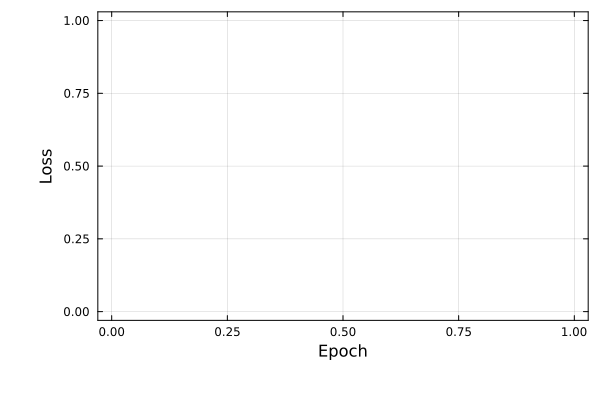

In [34]:
# 損失関数(Loss function)が学習とともに減少しているか確認
plot(loss_train, 
     linewidth=2, 
     xlabel="Epoch", ylabel="Loss", label=nothing,  
     size=(600, 400), frame_style=:box, 
     legend=:topright, 
     left_margin=Plots.Measures.Length(:mm, 10.0),
     bottom_margin=Plots.Measures.Length(:mm, 10.0))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


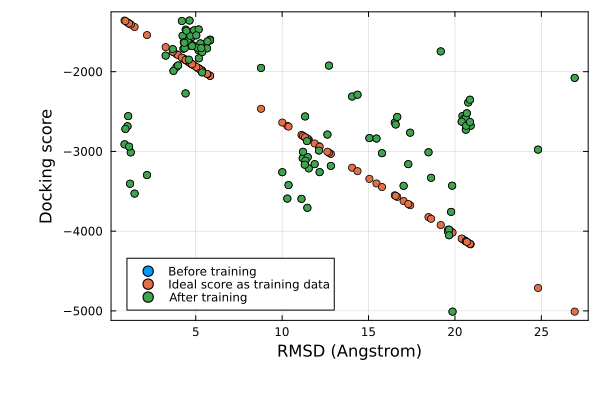

In [35]:
# 学習後のドッキングスコアをプロット
aftertrain_score = MDToolbox.docking_score(receptor, ligands, m.A[1], m.iface_score)

scatter(rmsds, current_score, 
        label="Before training", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:topright, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds, train_score, 
        label="Ideal score as training data", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, color=2, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds, aftertrain_score, 
        label="After training", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, color=3, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

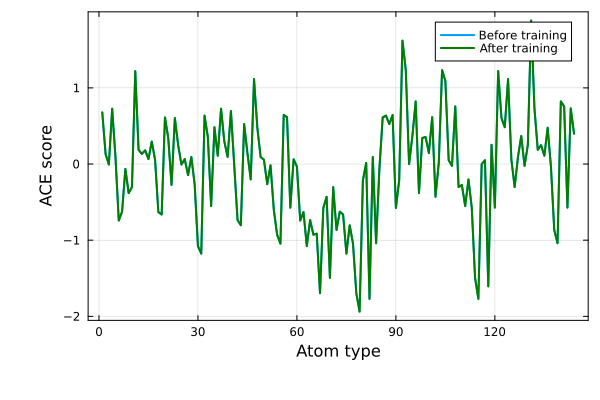

In [36]:
# 学習後の ace_scores をプロット
plot(iface_score[1:end], 
     linewidth=2, 
     xlabel="Atom type", ylabel="ACE score", label="Before training",  
     size=(600, 400), frame_style=:box, 
     legend=:topright, 
     left_margin=Plots.Measures.Length(:mm, 10.0),
     bottom_margin=Plots.Measures.Length(:mm, 10.0))

plot!(m.iface_score, 
     linewidth=2, 
     xlabel="Atom type", ylabel="ACE score", label="After training",
     linecolor=:green,
     size=(600, 400), frame_style=:box, 
     legend=:topright, 
     left_margin=Plots.Measures.Length(:mm, 10.0),
     bottom_margin=Plots.Measures.Length(:mm, 10.0))

In [37]:
m.iface_score

144-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
  0.678
  0.133
 -0.007
  0.727
  0.091
 -0.742
 -0.625
 -0.064
 -0.382
 -0.302
  1.221
  0.187
  0.133
  ⋮
  0.187
  0.248
  0.109
  0.477
 -0.034
 -0.867
 -1.04
  0.822
  0.757
 -0.572
  0.731
  0.399

In [38]:
@show m.iface_score

m.iface_score = Float32[0.678, 0.133, -0.007, 0.727, 0.091, -0.742, -0.625, -0.064, -0.382, -0.302, 1.221, 0.187, 0.133, 0.18, 0.065, 0.295, 0.057, -0.631, -0.663, 0.612, 0.342, -0.275, 0.604, 0.248, -0.007, 0.065, -0.145, 0.093, -0.265, -1.078, -1.176, 0.636, 0.355, -0.552, 0.483, 0.109, 0.727, 0.295, 0.093, 0.696, -0.016, -0.735, -0.804, 0.525, 0.144, -0.202, 1.116, 0.477, 0.091, 0.057, -0.265, -0.016, -0.601, -0.928, -1.046, 0.644, 0.615, -0.573, 0.062, -0.034, -0.742, -0.631, -1.078, -0.735, -0.928, -0.914, -1.696, -0.577, -0.43, -1.495, -0.303, -0.867, -0.625, -0.663, -1.176, -0.804, -1.046, -1.696, -1.938, -0.214, 0.015, -1.771, 0.092, -1.04, -0.064, 0.612, 0.636, 0.525, 0.644, -0.577, -0.214, 1.62, 1.233, -0.001, 0.368, 0.822, -0.382, 0.342, 0.355, 0.144, 0.615, -0.43, 0.015, 1.233, 1.09, 0.05, -0.024, 0.757, -0.302, -0.275, -0.552, -0.202, -0.573, -1.495, -1.771, -0.001, 0.05, -1.606, 0.253, -0.572, 1.221, 0.604, 0.483, 1.116, 0.062, -0.303, 0.092, 0.368, -0.024, 0.253, 1.884, 

144-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
  0.678
  0.133
 -0.007
  0.727
  0.091
 -0.742
 -0.625
 -0.064
 -0.382
 -0.302
  1.221
  0.187
  0.133
  ⋮
  0.187
  0.248
  0.109
  0.477
 -0.034
 -0.867
 -1.04
  0.822
  0.757
 -0.572
  0.731
  0.399

In [39]:
using BSON: @save, @load

@save "iface_trained.bson" m.iface_score

LoadError: LoadError: Unrecognised @save expression m.iface_score
in expression starting at In[39]:3

In [40]:
iface_score

12×12 Matrix{Float64}:
  0.678   0.133  -0.007   0.727   0.091  -0.742  -0.625  -0.064  -0.382  -0.302   1.221   0.187
  0.133   0.18    0.065   0.295   0.057  -0.631  -0.663   0.612   0.342  -0.275   0.604   0.248
 -0.007   0.065  -0.145   0.093  -0.265  -1.078  -1.176   0.636   0.355  -0.552   0.483   0.109
  0.727   0.295   0.093   0.696  -0.016  -0.735  -0.804   0.525   0.144  -0.202   1.116   0.477
  0.091   0.057  -0.265  -0.016  -0.601  -0.928  -1.046   0.644   0.615  -0.573   0.062  -0.034
 -0.742  -0.631  -1.078  -0.735  -0.928  -0.914  -1.696  -0.577  -0.43   -1.495  -0.303  -0.867
 -0.625  -0.663  -1.176  -0.804  -1.046  -1.696  -1.938  -0.214   0.015  -1.771   0.092  -1.04
 -0.064   0.612   0.636   0.525   0.644  -0.577  -0.214   1.62    1.233  -0.001   0.368   0.822
 -0.382   0.342   0.355   0.144   0.615  -0.43    0.015   1.233   1.09    0.05   -0.024   0.757
 -0.302  -0.275  -0.552  -0.202  -0.573  -1.495  -1.771  -0.001   0.05   -1.606   0.253  -0.572
  1.221   0.604   

In [41]:
m.A

1-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
 0.01

In [42]:
loss_train

Any[]